In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/kaggle/input/datasolar/Data_Solar_cut.csv',header=0)
    df.set_index('DATE (MM/DD/YYYY)', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

In [3]:
df = concat_csv()
print(df.info())  # Kiểm tra kiểu dữ liệu

/tmp/ipykernel_35/1504789278.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 26 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Azimuth Angle [degrees]                 float64
 2   Airmass                                 float64
 3   Tower Dry Bulb Temp [deg C]             float64
 4   Tower Wet Bulb Temp [deg C]             float64
 5   Tower Dew Point Temp [deg C]            float64
 6   Tower Wind Chill Temp [deg C]           float64
 7   Tower RH [%]                            float64
 8   Total Cloud Cover [%]                   int64  
 9   Opaque Cloud Cover [%]                  int64  
 10  Avg Wind Speed @ 19ft [m/s]             float64
 11  Peak Wind Speed @ 19ft [m/s]            float64
 12  Avg Wind Direction @ 19ft [deg from N]  float64
 13  Vertical Wind Shear [1/s]               float64
 14  Station P

In [4]:
def correlation(dataset, threshold):
     col_corr = set()  # Set of all the names of correlated columns
     corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
     num_columns = len(corr_matrix.columns)
     for i in range(num_columns):
         if i != 0:
             if abs(corr_matrix.iloc[i,25 ]) < threshold:
                 colname = corr_matrix.columns[i]
                 col_corr.add(colname)
     return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data

In [5]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# class LSTM(nn.Module):
#      def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
#          super(LSTM,self).__init__()
#          self.hidden_size = hidden_size
#          self.num_layers = num_layers
#          self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
#          self.fc = nn.Linear(hidden_size*seq_length,seq_length)
#      def forward(self,x):
#          out,(hidden,cell) = self.lstm(x)
#          # out: tensor of shape (batch_size, seq_length, hidden_size)

#          out = out.reshape(out.shape[0],-1)
#          # out: tensor of shape (batch_size, seq_length * hidden_size)

#          out = self.fc(out)
#          # out: shape (batch_size,seq_length)
#          return out

In [6]:
 device = "cuda" if torch.cuda.is_available() else "cpu"
 class LSTM(nn.Module):
     def __init__(self, input_size=8, hidden_size=256, num_layers=2, seq_length=12, dropout=0.3):
         super(LSTM, self).__init__()
         self.hidden_size = hidden_size
         self.num_layers = num_layers
         self.seq_length = seq_length
        # dropout giữa các layer của LSTM (áp dụng nếu num_layers > 1)
         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
         # Dropout sau LSTM trước khi vào fc
         self.dropout = nn.Dropout(dropout)
         self.fc = nn.Linear(hidden_size * seq_length, seq_length)

     def forward(self, x):
         out, (hidden, cell) = self.lstm(x)
         out = out.reshape(out.shape[0], -1)
         out = self.dropout(out)
         out = self.fc(out)
         return out

In [7]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]
        return torch.tensor(features),torch.tensor(targets)

In [8]:
df = df.iloc[:, [0, 2, 3, 7, 9, 12, 23, 25]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 8 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Airmass                                 float64
 2   Tower Dry Bulb Temp [deg C]             float64
 3   Tower RH [%]                            float64
 4   Opaque Cloud Cover [%]                  int64  
 5   Avg Wind Direction @ 19ft [deg from N]  float64
 6   Global Extraterrestrial (calc) [W/m^2]  float64
 7   GHI Mean                                float64
dtypes: float64(7), int64(1)
memory usage: 119.6+ MB
None


In [9]:
target_column = 'GHI Mean'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

In [10]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [11]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)

The shape of the original data: (1742341, 8)
The shape of the train data: (1393872, 8)
The shape of the train target: (1393872, 1)
The shape of the val data: (174234, 8)
The shape of the val target: (174234, 1)
The shape of the test data: (174235, 8)
The shape of the test target: (174235, 1)
58077
7258
7258


In [12]:
input_size = df.shape[1]
print(input_size)

8


In [13]:
#HYPERPARAMETERS
input_size = 8
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.001
batch_size = 16
num_epochs = 300
min_valid_loss = np.inf

In [14]:
# MODEL
model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             seq_length=sequence_length).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [15]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [16]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        patience: số epoch chờ đợi sau khi validation loss không giảm
        min_delta: mức giảm tối thiểu của validation loss để coi là cải thiện
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter nếu cải thiện
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [17]:
early_stopping = EarlyStopping(patience=20, min_delta=1e-5)  # Bạn có thể điều chỉnh
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data)
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    avg_train_loss = train_loss / len(train_data_loader)
    print("Train Loss:", avg_train_loss)
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    avg_valid_loss = valid_loss / len(val_data_loader)
    print("Validation Loss:", avg_valid_loss)

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, "model_predict_.pth.tar")

     # Kiểm tra EarlyStopping
    early_stopping(avg_valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch:  0


100%|██████████| 3630/3630 [00:12<00:00, 298.61it/s]


Train Loss: 0.10862890256946578


100%|██████████| 454/454 [00:00<00:00, 998.31it/s] 


Validation Loss: 0.0783423074753955
Validation Loss Decreased(inf--->0.078342 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 3630/3630 [00:11<00:00, 313.85it/s]


Train Loss: 0.09353638070899437


100%|██████████| 454/454 [00:00<00:00, 1007.23it/s]


Validation Loss: 0.06395050587446946
Validation Loss Decreased(0.078342--->0.063951 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 3630/3630 [00:12<00:00, 288.01it/s]


Train Loss: 0.08964519919171741


100%|██████████| 454/454 [00:00<00:00, 980.24it/s] 


Validation Loss: 0.052800256780339484
Validation Loss Decreased(0.063951--->0.052800 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 3630/3630 [00:11<00:00, 313.09it/s]


Train Loss: 0.08710655617140735


100%|██████████| 454/454 [00:00<00:00, 983.37it/s] 


Validation Loss: 0.045878237488885754
Validation Loss Decreased(0.052800--->0.045878 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 3630/3630 [00:11<00:00, 304.94it/s]


Train Loss: 0.08499963635592542


100%|██████████| 454/454 [00:00<00:00, 1005.78it/s]


Validation Loss: 0.040720504372836336
Validation Loss Decreased(0.045878--->0.040721 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 3630/3630 [00:11<00:00, 313.69it/s]


Train Loss: 0.0845692976240483


100%|██████████| 454/454 [00:00<00:00, 994.66it/s] 


Validation Loss: 0.03733646663908484
Validation Loss Decreased(0.040721--->0.037336 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 3630/3630 [00:11<00:00, 311.03it/s]


Train Loss: 0.0836361287774091


100%|██████████| 454/454 [00:00<00:00, 984.90it/s]


Validation Loss: 0.03702816676813468
Validation Loss Decreased(0.037336--->0.037028 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 3630/3630 [00:11<00:00, 305.38it/s]


Train Loss: 0.08347385629970508


100%|██████████| 454/454 [00:00<00:00, 1001.23it/s]


Validation Loss: 0.036891467892680226
Validation Loss Decreased(0.037028--->0.036891 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 3630/3630 [00:11<00:00, 307.50it/s]


Train Loss: 0.08325659334440697


100%|██████████| 454/454 [00:00<00:00, 945.59it/s]


Validation Loss: 0.03679831785678485
Validation Loss Decreased(0.036891--->0.036798 	 Saving The Model
=> Saving checkpoint
Epoch:  9


100%|██████████| 3630/3630 [00:11<00:00, 303.87it/s]


Train Loss: 0.08295496729219085


100%|██████████| 454/454 [00:00<00:00, 1004.77it/s]


Validation Loss: 0.036766612019697185
Validation Loss Decreased(0.036798--->0.036767 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 3630/3630 [00:11<00:00, 309.50it/s]


Train Loss: 0.08327068918353023


100%|██████████| 454/454 [00:00<00:00, 976.93it/s]


Validation Loss: 0.03670113973793686
Validation Loss Decreased(0.036767--->0.036701 	 Saving The Model
=> Saving checkpoint
Epoch:  11


100%|██████████| 3630/3630 [00:11<00:00, 315.25it/s]


Train Loss: 0.08318742974947518


100%|██████████| 454/454 [00:00<00:00, 988.05it/s]


Validation Loss: 0.036679554891846676
Validation Loss Decreased(0.036701--->0.036680 	 Saving The Model
=> Saving checkpoint
Epoch:  12


100%|██████████| 3630/3630 [00:11<00:00, 309.85it/s]


Train Loss: 0.08317281849879243


100%|██████████| 454/454 [00:00<00:00, 1027.09it/s]


Validation Loss: 0.03666778437092647
Validation Loss Decreased(0.036680--->0.036668 	 Saving The Model
=> Saving checkpoint
Epoch:  13


100%|██████████| 3630/3630 [00:11<00:00, 312.82it/s]


Train Loss: 0.08302942077514937


100%|██████████| 454/454 [00:00<00:00, 1007.55it/s]


Validation Loss: 0.03663121870407857
Validation Loss Decreased(0.036668--->0.036631 	 Saving The Model
=> Saving checkpoint
Epoch:  14


100%|██████████| 3630/3630 [00:11<00:00, 315.39it/s]


Train Loss: 0.082937758764093


100%|██████████| 454/454 [00:00<00:00, 1018.74it/s]


Validation Loss: 0.03663266080309263
EarlyStopping counter: 1 out of 20
Epoch:  15


100%|██████████| 3630/3630 [00:11<00:00, 314.63it/s]


Train Loss: 0.08285101628948109


100%|██████████| 454/454 [00:00<00:00, 912.79it/s] 


Validation Loss: 0.03660273621548114
Validation Loss Decreased(0.036631--->0.036603 	 Saving The Model
=> Saving checkpoint
Epoch:  16


100%|██████████| 3630/3630 [00:11<00:00, 313.29it/s]


Train Loss: 0.08299707620636049


100%|██████████| 454/454 [00:00<00:00, 1014.08it/s]


Validation Loss: 0.036600890553827294
Validation Loss Decreased(0.036603--->0.036601 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  17


100%|██████████| 3630/3630 [00:11<00:00, 311.28it/s]


Train Loss: 0.0825616754713172


100%|██████████| 454/454 [00:00<00:00, 1009.46it/s]


Validation Loss: 0.03653389966433126
Validation Loss Decreased(0.036601--->0.036534 	 Saving The Model
=> Saving checkpoint
Epoch:  18


100%|██████████| 3630/3630 [00:11<00:00, 310.94it/s]


Train Loss: 0.08281300251262157


100%|██████████| 454/454 [00:00<00:00, 1008.93it/s]


Validation Loss: 0.03649387694678912
Validation Loss Decreased(0.036534--->0.036494 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 3630/3630 [00:11<00:00, 312.75it/s]


Train Loss: 0.08232929358017033


100%|██████████| 454/454 [00:00<00:00, 999.67it/s] 


Validation Loss: 0.036466847032389095
Validation Loss Decreased(0.036494--->0.036467 	 Saving The Model
=> Saving checkpoint
Epoch:  20


100%|██████████| 3630/3630 [00:11<00:00, 308.62it/s]


Train Loss: 0.0826248564520006


100%|██████████| 454/454 [00:00<00:00, 1003.55it/s]


Validation Loss: 0.0364449071824627
Validation Loss Decreased(0.036467--->0.036445 	 Saving The Model
=> Saving checkpoint
Epoch:  21


100%|██████████| 3630/3630 [00:11<00:00, 314.29it/s]


Train Loss: 0.08237225412014781


100%|██████████| 454/454 [00:00<00:00, 1014.70it/s]


Validation Loss: 0.03640533225055828
Validation Loss Decreased(0.036445--->0.036405 	 Saving The Model
=> Saving checkpoint
Epoch:  22


100%|██████████| 3630/3630 [00:11<00:00, 310.55it/s]


Train Loss: 0.08274060186153738


100%|██████████| 454/454 [00:00<00:00, 878.61it/s]


Validation Loss: 0.03639600822927829
Validation Loss Decreased(0.036405--->0.036396 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  23


100%|██████████| 3630/3630 [00:11<00:00, 311.93it/s]


Train Loss: 0.08263299728652491


100%|██████████| 454/454 [00:00<00:00, 1000.83it/s]


Validation Loss: 0.036386581962860355
Validation Loss Decreased(0.036396--->0.036387 	 Saving The Model
=> Saving checkpoint
Epoch:  24


100%|██████████| 3630/3630 [00:11<00:00, 315.15it/s]


Train Loss: 0.0824943371769987


100%|██████████| 454/454 [00:00<00:00, 1009.81it/s]


Validation Loss: 0.0363466667686666
Validation Loss Decreased(0.036387--->0.036347 	 Saving The Model
=> Saving checkpoint
Epoch:  25


100%|██████████| 3630/3630 [00:11<00:00, 307.42it/s]


Train Loss: 0.08230068032225221


100%|██████████| 454/454 [00:00<00:00, 1014.64it/s]


Validation Loss: 0.03635171643062905
EarlyStopping counter: 1 out of 20
Epoch:  26


100%|██████████| 3630/3630 [00:11<00:00, 314.78it/s]


Train Loss: 0.08241172590814615


100%|██████████| 454/454 [00:00<00:00, 988.04it/s]


Validation Loss: 0.0363069770535947
Validation Loss Decreased(0.036347--->0.036307 	 Saving The Model
=> Saving checkpoint
Epoch:  27


100%|██████████| 3630/3630 [00:11<00:00, 311.17it/s]


Train Loss: 0.0822542157235649


100%|██████████| 454/454 [00:00<00:00, 999.05it/s] 


Validation Loss: 0.03628158519181512
Validation Loss Decreased(0.036307--->0.036282 	 Saving The Model
=> Saving checkpoint
Epoch:  28


100%|██████████| 3630/3630 [00:11<00:00, 308.58it/s]


Train Loss: 0.08227215419262365


100%|██████████| 454/454 [00:00<00:00, 997.86it/s] 


Validation Loss: 0.03625965867552979
Validation Loss Decreased(0.036282--->0.036260 	 Saving The Model
=> Saving checkpoint
Epoch:  29


100%|██████████| 3630/3630 [00:11<00:00, 312.92it/s]


Train Loss: 0.08188408430874669


100%|██████████| 454/454 [00:00<00:00, 1026.06it/s]


Validation Loss: 0.03624780182112552
Validation Loss Decreased(0.036260--->0.036248 	 Saving The Model
=> Saving checkpoint
Epoch:  30


100%|██████████| 3630/3630 [00:11<00:00, 310.68it/s]


Train Loss: 0.08250733807454651


100%|██████████| 454/454 [00:00<00:00, 1000.46it/s]


Validation Loss: 0.03620402091074751
Validation Loss Decreased(0.036248--->0.036204 	 Saving The Model
=> Saving checkpoint
Epoch:  31


100%|██████████| 3630/3630 [00:11<00:00, 311.79it/s]


Train Loss: 0.08226074540697213


100%|██████████| 454/454 [00:00<00:00, 1003.61it/s]


Validation Loss: 0.03620814558501034
EarlyStopping counter: 1 out of 20
Epoch:  32


100%|██████████| 3630/3630 [00:11<00:00, 305.51it/s]


Train Loss: 0.08192409742235517


100%|██████████| 454/454 [00:00<00:00, 990.17it/s] 


Validation Loss: 0.036181137652672564
Validation Loss Decreased(0.036204--->0.036181 	 Saving The Model
=> Saving checkpoint
Epoch:  33


100%|██████████| 3630/3630 [00:11<00:00, 306.16it/s]


Train Loss: 0.08201561730059817


100%|██████████| 454/454 [00:00<00:00, 916.85it/s]


Validation Loss: 0.03616515261098401
Validation Loss Decreased(0.036181--->0.036165 	 Saving The Model
=> Saving checkpoint
Epoch:  34


100%|██████████| 3630/3630 [00:11<00:00, 309.18it/s]


Train Loss: 0.08152943751242361


100%|██████████| 454/454 [00:00<00:00, 990.40it/s]


Validation Loss: 0.03613168107285313
Validation Loss Decreased(0.036165--->0.036132 	 Saving The Model
=> Saving checkpoint
Epoch:  35


100%|██████████| 3630/3630 [00:11<00:00, 309.62it/s]


Train Loss: 0.08188889597477


100%|██████████| 454/454 [00:00<00:00, 985.96it/s]


Validation Loss: 0.03611311863289606
Validation Loss Decreased(0.036132--->0.036113 	 Saving The Model
=> Saving checkpoint
Epoch:  36


100%|██████████| 3630/3630 [00:11<00:00, 308.16it/s]


Train Loss: 0.0819375267679102


100%|██████████| 454/454 [00:00<00:00, 971.73it/s]


Validation Loss: 0.036111274960751866
Validation Loss Decreased(0.036113--->0.036111 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  37


100%|██████████| 3630/3630 [00:11<00:00, 313.91it/s]


Train Loss: 0.08169710761064101


100%|██████████| 454/454 [00:00<00:00, 998.66it/s] 


Validation Loss: 0.036074335802252104
Validation Loss Decreased(0.036111--->0.036074 	 Saving The Model
=> Saving checkpoint
Epoch:  38


100%|██████████| 3630/3630 [00:11<00:00, 311.09it/s]


Train Loss: 0.08175601218929694


100%|██████████| 454/454 [00:00<00:00, 1018.81it/s]


Validation Loss: 0.036080865210315415
EarlyStopping counter: 1 out of 20
Epoch:  39


100%|██████████| 3630/3630 [00:11<00:00, 314.85it/s]


Train Loss: 0.08149239802025111


100%|██████████| 454/454 [00:00<00:00, 1020.15it/s]


Validation Loss: 0.03602473959582845
Validation Loss Decreased(0.036074--->0.036025 	 Saving The Model
=> Saving checkpoint
Epoch:  40


100%|██████████| 3630/3630 [00:11<00:00, 311.49it/s]


Train Loss: 0.08163271632944118


100%|██████████| 454/454 [00:00<00:00, 1034.51it/s]


Validation Loss: 0.03598575492468734
Validation Loss Decreased(0.036025--->0.035986 	 Saving The Model
=> Saving checkpoint
Epoch:  41


100%|██████████| 3630/3630 [00:11<00:00, 310.66it/s]


Train Loss: 0.08162655678533465


100%|██████████| 454/454 [00:00<00:00, 1001.88it/s]


Validation Loss: 0.03599916334448732
EarlyStopping counter: 1 out of 20
Epoch:  42


100%|██████████| 3630/3630 [00:11<00:00, 312.28it/s]


Train Loss: 0.0816382518464609


100%|██████████| 454/454 [00:00<00:00, 1019.18it/s]


Validation Loss: 0.03596435434623834
Validation Loss Decreased(0.035986--->0.035964 	 Saving The Model
=> Saving checkpoint
Epoch:  43


100%|██████████| 3630/3630 [00:11<00:00, 307.51it/s]


Train Loss: 0.08168428647784887


100%|██████████| 454/454 [00:00<00:00, 976.31it/s]


Validation Loss: 0.035939619689497104
Validation Loss Decreased(0.035964--->0.035940 	 Saving The Model
=> Saving checkpoint
Epoch:  44


100%|██████████| 3630/3630 [00:11<00:00, 313.17it/s]


Train Loss: 0.08139801310367636


100%|██████████| 454/454 [00:00<00:00, 1005.09it/s]


Validation Loss: 0.03595179626845413
EarlyStopping counter: 1 out of 20
Epoch:  45


100%|██████████| 3630/3630 [00:11<00:00, 313.45it/s]


Train Loss: 0.08182698589408566


100%|██████████| 454/454 [00:00<00:00, 993.93it/s] 


Validation Loss: 0.0359284289672023
Validation Loss Decreased(0.035940--->0.035928 	 Saving The Model
=> Saving checkpoint
Epoch:  46


100%|██████████| 3630/3630 [00:11<00:00, 304.76it/s]


Train Loss: 0.08129906663433815


100%|██████████| 454/454 [00:00<00:00, 1023.90it/s]


Validation Loss: 0.03590057628531966
Validation Loss Decreased(0.035928--->0.035901 	 Saving The Model
=> Saving checkpoint
Epoch:  47


100%|██████████| 3630/3630 [00:11<00:00, 312.66it/s]


Train Loss: 0.08143075283722774


100%|██████████| 454/454 [00:00<00:00, 1027.03it/s]


Validation Loss: 0.035876582120141345
Validation Loss Decreased(0.035901--->0.035877 	 Saving The Model
=> Saving checkpoint
Epoch:  48


100%|██████████| 3630/3630 [00:11<00:00, 314.02it/s]


Train Loss: 0.08138837511934238


100%|██████████| 454/454 [00:00<00:00, 992.94it/s]


Validation Loss: 0.03586832562957414
Validation Loss Decreased(0.035877--->0.035868 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  49


100%|██████████| 3630/3630 [00:11<00:00, 308.11it/s]


Train Loss: 0.08144779897890805


100%|██████████| 454/454 [00:00<00:00, 1022.96it/s]


Validation Loss: 0.03583201642882139
Validation Loss Decreased(0.035868--->0.035832 	 Saving The Model
=> Saving checkpoint
Epoch:  50


100%|██████████| 3630/3630 [00:11<00:00, 313.65it/s]


Train Loss: 0.08114160033951984


100%|██████████| 454/454 [00:00<00:00, 974.13it/s] 


Validation Loss: 0.035858987715414015
EarlyStopping counter: 1 out of 20
Epoch:  51


100%|██████████| 3630/3630 [00:11<00:00, 308.41it/s]


Train Loss: 0.08117864975055036


100%|██████████| 454/454 [00:00<00:00, 991.13it/s] 


Validation Loss: 0.035812287996030756
Validation Loss Decreased(0.035832--->0.035812 	 Saving The Model
=> Saving checkpoint
Epoch:  52


100%|██████████| 3630/3630 [00:11<00:00, 313.06it/s]


Train Loss: 0.08123770149467326


100%|██████████| 454/454 [00:00<00:00, 1003.75it/s]


Validation Loss: 0.03576726774006017
Validation Loss Decreased(0.035812--->0.035767 	 Saving The Model
=> Saving checkpoint
Epoch:  53


100%|██████████| 3630/3630 [00:11<00:00, 311.05it/s]


Train Loss: 0.080955828180214


100%|██████████| 454/454 [00:00<00:00, 1005.00it/s]


Validation Loss: 0.035756049369479015
Validation Loss Decreased(0.035767--->0.035756 	 Saving The Model
=> Saving checkpoint
Epoch:  54


100%|██████████| 3630/3630 [00:11<00:00, 307.06it/s]


Train Loss: 0.08120094417892948


100%|██████████| 454/454 [00:00<00:00, 1016.33it/s]


Validation Loss: 0.03575210388742017
Validation Loss Decreased(0.035756--->0.035752 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  55


100%|██████████| 3630/3630 [00:11<00:00, 312.44it/s]


Train Loss: 0.08121220368615989


100%|██████████| 454/454 [00:00<00:00, 988.16it/s]


Validation Loss: 0.035734234868211874
Validation Loss Decreased(0.035752--->0.035734 	 Saving The Model
=> Saving checkpoint
Epoch:  56


100%|██████████| 3630/3630 [00:11<00:00, 308.65it/s]


Train Loss: 0.08114393490570926


100%|██████████| 454/454 [00:00<00:00, 916.72it/s] 


Validation Loss: 0.03573392437947765
Validation Loss Decreased(0.035734--->0.035734 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  57


100%|██████████| 3630/3630 [00:11<00:00, 309.86it/s]


Train Loss: 0.08101847902201398


100%|██████████| 454/454 [00:00<00:00, 999.18it/s] 


Validation Loss: 0.03570056623586408
Validation Loss Decreased(0.035734--->0.035701 	 Saving The Model
=> Saving checkpoint
Epoch:  58


100%|██████████| 3630/3630 [00:11<00:00, 311.62it/s]


Train Loss: 0.08079534446848358


100%|██████████| 454/454 [00:00<00:00, 1000.01it/s]


Validation Loss: 0.03565889152406924
Validation Loss Decreased(0.035701--->0.035659 	 Saving The Model
=> Saving checkpoint
Epoch:  59


100%|██████████| 3630/3630 [00:11<00:00, 308.73it/s]


Train Loss: 0.08095048929771669


100%|██████████| 454/454 [00:00<00:00, 988.17it/s]


Validation Loss: 0.0356870449873086
EarlyStopping counter: 1 out of 20
Epoch:  60


100%|██████████| 3630/3630 [00:11<00:00, 308.41it/s]


Train Loss: 0.08061449415630599


100%|██████████| 454/454 [00:00<00:00, 990.03it/s]


Validation Loss: 0.0355840103228557
Validation Loss Decreased(0.035659--->0.035584 	 Saving The Model
=> Saving checkpoint
Epoch:  61


100%|██████████| 3630/3630 [00:11<00:00, 307.82it/s]


Train Loss: 0.08067140778417303


100%|██████████| 454/454 [00:00<00:00, 1006.92it/s]


Validation Loss: 0.03564333600824953
EarlyStopping counter: 1 out of 20
Epoch:  62


100%|██████████| 3630/3630 [00:11<00:00, 311.30it/s]


Train Loss: 0.08096673766601017


100%|██████████| 454/454 [00:00<00:00, 1012.12it/s]


Validation Loss: 0.03560769735178541
EarlyStopping counter: 2 out of 20
Epoch:  63


100%|██████████| 3630/3630 [00:11<00:00, 313.68it/s]


Train Loss: 0.0808533223772331


100%|██████████| 454/454 [00:00<00:00, 992.27it/s]


Validation Loss: 0.03559767020744346
EarlyStopping counter: 3 out of 20
Epoch:  64


100%|██████████| 3630/3630 [00:11<00:00, 305.10it/s]


Train Loss: 0.08075266262017204


100%|██████████| 454/454 [00:00<00:00, 1019.38it/s]


Validation Loss: 0.035580130978354094
Validation Loss Decreased(0.035584--->0.035580 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  65


100%|██████████| 3630/3630 [00:11<00:00, 310.97it/s]


Train Loss: 0.08076513285195287


100%|██████████| 454/454 [00:00<00:00, 1015.25it/s]


Validation Loss: 0.035560190091976314
Validation Loss Decreased(0.035580--->0.035560 	 Saving The Model
=> Saving checkpoint
Epoch:  66


100%|██████████| 3630/3630 [00:11<00:00, 311.16it/s]


Train Loss: 0.08050602853483232


100%|██████████| 454/454 [00:00<00:00, 963.74it/s]


Validation Loss: 0.03554328054884327
Validation Loss Decreased(0.035560--->0.035543 	 Saving The Model
=> Saving checkpoint
Epoch:  67


100%|██████████| 3630/3630 [00:11<00:00, 309.09it/s]


Train Loss: 0.080517340906998


100%|██████████| 454/454 [00:00<00:00, 1006.98it/s]


Validation Loss: 0.03555163611580478
EarlyStopping counter: 1 out of 20
Epoch:  68


100%|██████████| 3630/3630 [00:11<00:00, 311.89it/s]


Train Loss: 0.080230600858773


100%|██████████| 454/454 [00:00<00:00, 998.52it/s] 


Validation Loss: 0.03551560480231963
Validation Loss Decreased(0.035543--->0.035516 	 Saving The Model
=> Saving checkpoint
Epoch:  69


100%|██████████| 3630/3630 [00:11<00:00, 311.16it/s]


Train Loss: 0.0802075231076281


100%|██████████| 454/454 [00:00<00:00, 1018.07it/s]


Validation Loss: 0.035514468546501116
Validation Loss Decreased(0.035516--->0.035514 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  70


100%|██████████| 3630/3630 [00:11<00:00, 304.78it/s]


Train Loss: 0.08015227019557532


100%|██████████| 454/454 [00:00<00:00, 990.43it/s]


Validation Loss: 0.035491942873103845
Validation Loss Decreased(0.035514--->0.035492 	 Saving The Model
=> Saving checkpoint
Epoch:  71


100%|██████████| 3630/3630 [00:11<00:00, 311.37it/s]


Train Loss: 0.08006063630978721


100%|██████████| 454/454 [00:00<00:00, 995.98it/s]


Validation Loss: 0.0354633614539037
Validation Loss Decreased(0.035492--->0.035463 	 Saving The Model
=> Saving checkpoint
Epoch:  72


100%|██████████| 3630/3630 [00:11<00:00, 306.13it/s]


Train Loss: 0.0804006365853533


100%|██████████| 454/454 [00:00<00:00, 1020.26it/s]


Validation Loss: 0.03544543438442915
Validation Loss Decreased(0.035463--->0.035445 	 Saving The Model
=> Saving checkpoint
Epoch:  73


100%|██████████| 3630/3630 [00:11<00:00, 313.76it/s]


Train Loss: 0.08027572520923885


100%|██████████| 454/454 [00:00<00:00, 957.38it/s] 


Validation Loss: 0.03542202214635026
Validation Loss Decreased(0.035445--->0.035422 	 Saving The Model
=> Saving checkpoint
Epoch:  74


100%|██████████| 3630/3630 [00:11<00:00, 314.75it/s]


Train Loss: 0.08048079424549263


100%|██████████| 454/454 [00:00<00:00, 1013.46it/s]


Validation Loss: 0.0354458638656967
EarlyStopping counter: 1 out of 20
Epoch:  75


100%|██████████| 3630/3630 [00:11<00:00, 309.06it/s]


Train Loss: 0.08031838730709774


100%|██████████| 454/454 [00:00<00:00, 1009.30it/s]


Validation Loss: 0.03545389267485071
EarlyStopping counter: 2 out of 20
Epoch:  76


100%|██████████| 3630/3630 [00:11<00:00, 313.16it/s]


Train Loss: 0.0803302310766109


100%|██████████| 454/454 [00:00<00:00, 1010.82it/s]


Validation Loss: 0.03547916248143165
EarlyStopping counter: 3 out of 20
Epoch:  77


100%|██████████| 3630/3630 [00:11<00:00, 309.76it/s]


Train Loss: 0.08019355937678845


100%|██████████| 454/454 [00:00<00:00, 958.84it/s]


Validation Loss: 0.03544231959000524
EarlyStopping counter: 4 out of 20
Epoch:  78


100%|██████████| 3630/3630 [00:11<00:00, 311.72it/s]


Train Loss: 0.08031012742798109


100%|██████████| 454/454 [00:00<00:00, 1012.37it/s]


Validation Loss: 0.03541646399392925
Validation Loss Decreased(0.035422--->0.035416 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  79


100%|██████████| 3630/3630 [00:11<00:00, 313.58it/s]


Train Loss: 0.08019754461201355


100%|██████████| 454/454 [00:00<00:00, 971.06it/s] 


Validation Loss: 0.03541293399350637
Validation Loss Decreased(0.035416--->0.035413 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 6 out of 20
Epoch:  80


100%|██████████| 3630/3630 [00:11<00:00, 305.09it/s]


Train Loss: 0.07993326338408765


100%|██████████| 454/454 [00:00<00:00, 999.86it/s] 


Validation Loss: 0.03538488056907499
Validation Loss Decreased(0.035413--->0.035385 	 Saving The Model
=> Saving checkpoint
Epoch:  81


100%|██████████| 3630/3630 [00:11<00:00, 311.63it/s]


Train Loss: 0.08021755182819593


100%|██████████| 454/454 [00:00<00:00, 995.91it/s]


Validation Loss: 0.0353822309772165
Validation Loss Decreased(0.035385--->0.035382 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  82


100%|██████████| 3630/3630 [00:11<00:00, 312.95it/s]


Train Loss: 0.08017362834068403


100%|██████████| 454/454 [00:00<00:00, 1018.17it/s]


Validation Loss: 0.03538941281046275
EarlyStopping counter: 2 out of 20
Epoch:  83


100%|██████████| 3630/3630 [00:11<00:00, 309.59it/s]


Train Loss: 0.07967459686276389


100%|██████████| 454/454 [00:00<00:00, 996.31it/s] 


Validation Loss: 0.03534348036840726
Validation Loss Decreased(0.035382--->0.035343 	 Saving The Model
=> Saving checkpoint
Epoch:  84


100%|██████████| 3630/3630 [00:11<00:00, 310.37it/s]


Train Loss: 0.07997669638776747


100%|██████████| 454/454 [00:00<00:00, 1016.74it/s]


Validation Loss: 0.03534523495592204
EarlyStopping counter: 1 out of 20
Epoch:  85


100%|██████████| 3630/3630 [00:11<00:00, 303.65it/s]


Train Loss: 0.07980958774327314


100%|██████████| 454/454 [00:00<00:00, 971.17it/s]


Validation Loss: 0.03541919072103504
EarlyStopping counter: 2 out of 20
Epoch:  86


100%|██████████| 3630/3630 [00:11<00:00, 308.12it/s]


Train Loss: 0.07993136653904329


100%|██████████| 454/454 [00:00<00:00, 991.50it/s]


Validation Loss: 0.035354256507919304
EarlyStopping counter: 3 out of 20
Epoch:  87


100%|██████████| 3630/3630 [00:11<00:00, 309.59it/s]


Train Loss: 0.08011868130529126


100%|██████████| 454/454 [00:00<00:00, 989.43it/s]


Validation Loss: 0.03539560730863308
EarlyStopping counter: 4 out of 20
Epoch:  88


100%|██████████| 3630/3630 [00:11<00:00, 307.24it/s]


Train Loss: 0.07965395041420247


100%|██████████| 454/454 [00:00<00:00, 980.17it/s]


Validation Loss: 0.035321110543698256
Validation Loss Decreased(0.035343--->0.035321 	 Saving The Model
=> Saving checkpoint
Epoch:  89


100%|██████████| 3630/3630 [00:11<00:00, 310.71it/s]


Train Loss: 0.07936901648974812


100%|██████████| 454/454 [00:00<00:00, 942.08it/s] 


Validation Loss: 0.035335619378238016
EarlyStopping counter: 1 out of 20
Epoch:  90


100%|██████████| 3630/3630 [00:11<00:00, 309.46it/s]


Train Loss: 0.07983365043034131


100%|██████████| 454/454 [00:00<00:00, 868.79it/s]


Validation Loss: 0.03534456565798571
EarlyStopping counter: 2 out of 20
Epoch:  91


100%|██████████| 3630/3630 [00:11<00:00, 308.86it/s]


Train Loss: 0.08000748896217372


100%|██████████| 454/454 [00:00<00:00, 1013.59it/s]


Validation Loss: 0.03530777810313375
Validation Loss Decreased(0.035321--->0.035308 	 Saving The Model
=> Saving checkpoint
Epoch:  92


100%|██████████| 3630/3630 [00:11<00:00, 311.13it/s]


Train Loss: 0.07950658599991825


100%|██████████| 454/454 [00:00<00:00, 1009.39it/s]


Validation Loss: 0.03527094443114695
Validation Loss Decreased(0.035308--->0.035271 	 Saving The Model
=> Saving checkpoint
Epoch:  93


100%|██████████| 3630/3630 [00:11<00:00, 308.05it/s]


Train Loss: 0.07951029223124863


100%|██████████| 454/454 [00:00<00:00, 1007.19it/s]


Validation Loss: 0.03531572679876984
EarlyStopping counter: 1 out of 20
Epoch:  94


100%|██████████| 3630/3630 [00:11<00:00, 311.81it/s]


Train Loss: 0.07983870440690756


100%|██████████| 454/454 [00:00<00:00, 998.30it/s] 


Validation Loss: 0.03529253825072855
EarlyStopping counter: 2 out of 20
Epoch:  95


100%|██████████| 3630/3630 [00:11<00:00, 311.29it/s]


Train Loss: 0.07932997575347547


100%|██████████| 454/454 [00:00<00:00, 1004.61it/s]


Validation Loss: 0.03539492537655728
EarlyStopping counter: 3 out of 20
Epoch:  96


100%|██████████| 3630/3630 [00:11<00:00, 306.75it/s]


Train Loss: 0.07951679136159896


100%|██████████| 454/454 [00:00<00:00, 950.91it/s]


Validation Loss: 0.035299862236378016
EarlyStopping counter: 4 out of 20
Epoch:  97


100%|██████████| 3630/3630 [00:11<00:00, 312.46it/s]


Train Loss: 0.07945968943947737


100%|██████████| 454/454 [00:00<00:00, 1029.03it/s]


Validation Loss: 0.035239118058606266
Validation Loss Decreased(0.035271--->0.035239 	 Saving The Model
=> Saving checkpoint
Epoch:  98


100%|██████████| 3630/3630 [00:11<00:00, 308.84it/s]


Train Loss: 0.07934514808347616


100%|██████████| 454/454 [00:00<00:00, 1014.31it/s]


Validation Loss: 0.03524088170566588
EarlyStopping counter: 1 out of 20
Epoch:  99


100%|██████████| 3630/3630 [00:11<00:00, 312.18it/s]


Train Loss: 0.07929177498127418


100%|██████████| 454/454 [00:00<00:00, 994.59it/s] 


Validation Loss: 0.035222225387489405
Validation Loss Decreased(0.035239--->0.035222 	 Saving The Model
=> Saving checkpoint
Epoch:  100


100%|██████████| 3630/3630 [00:11<00:00, 309.10it/s]


Train Loss: 0.07927521404409531


100%|██████████| 454/454 [00:00<00:00, 1012.67it/s]


Validation Loss: 0.03533285509465833
EarlyStopping counter: 1 out of 20
Epoch:  101


100%|██████████| 3630/3630 [00:11<00:00, 307.88it/s]


Train Loss: 0.07931578821530207


100%|██████████| 454/454 [00:00<00:00, 1006.43it/s]


Validation Loss: 0.03524096264518128
EarlyStopping counter: 2 out of 20
Epoch:  102


100%|██████████| 3630/3630 [00:11<00:00, 312.05it/s]


Train Loss: 0.07932940863981906


100%|██████████| 454/454 [00:00<00:00, 994.13it/s] 


Validation Loss: 0.03519763297913314
Validation Loss Decreased(0.035222--->0.035198 	 Saving The Model
=> Saving checkpoint
Epoch:  103


100%|██████████| 3630/3630 [00:11<00:00, 309.76it/s]


Train Loss: 0.0793438525776316


100%|██████████| 454/454 [00:00<00:00, 990.50it/s]


Validation Loss: 0.03527717520793108
EarlyStopping counter: 1 out of 20
Epoch:  104


100%|██████████| 3630/3630 [00:11<00:00, 305.35it/s]


Train Loss: 0.07939631045926984


100%|██████████| 454/454 [00:00<00:00, 1006.97it/s]


Validation Loss: 0.03525172147321892
EarlyStopping counter: 2 out of 20
Epoch:  105


100%|██████████| 3630/3630 [00:11<00:00, 313.55it/s]


Train Loss: 0.07932623281948892


100%|██████████| 454/454 [00:00<00:00, 983.72it/s] 


Validation Loss: 0.03522964260381409
EarlyStopping counter: 3 out of 20
Epoch:  106


100%|██████████| 3630/3630 [00:11<00:00, 310.62it/s]


Train Loss: 0.07912939033856213


100%|██████████| 454/454 [00:00<00:00, 988.24it/s]


Validation Loss: 0.03520513460852179
EarlyStopping counter: 4 out of 20
Epoch:  107


100%|██████████| 3630/3630 [00:11<00:00, 310.67it/s]


Train Loss: 0.07913756940992339


100%|██████████| 454/454 [00:00<00:00, 987.93it/s] 


Validation Loss: 0.03514593012304899
Validation Loss Decreased(0.035198--->0.035146 	 Saving The Model
=> Saving checkpoint
Epoch:  108


100%|██████████| 3630/3630 [00:11<00:00, 312.68it/s]


Train Loss: 0.0790275321576405


100%|██████████| 454/454 [00:00<00:00, 987.73it/s]


Validation Loss: 0.03512020664874747
Validation Loss Decreased(0.035146--->0.035120 	 Saving The Model
=> Saving checkpoint
Epoch:  109


100%|██████████| 3630/3630 [00:11<00:00, 306.24it/s]


Train Loss: 0.07884209557374992


100%|██████████| 454/454 [00:00<00:00, 988.15it/s] 


Validation Loss: 0.035151032425507045
EarlyStopping counter: 1 out of 20
Epoch:  110


100%|██████████| 3630/3630 [00:11<00:00, 310.21it/s]


Train Loss: 0.07902720876761421


100%|██████████| 454/454 [00:00<00:00, 994.33it/s]


Validation Loss: 0.035151840548682596
EarlyStopping counter: 2 out of 20
Epoch:  111


100%|██████████| 3630/3630 [00:11<00:00, 306.48it/s]


Train Loss: 0.07943086231050572


100%|██████████| 454/454 [00:00<00:00, 993.06it/s] 


Validation Loss: 0.035124827250694685
EarlyStopping counter: 3 out of 20
Epoch:  112


100%|██████████| 3630/3630 [00:11<00:00, 311.00it/s]


Train Loss: 0.078910353166175


100%|██████████| 454/454 [00:00<00:00, 1007.39it/s]


Validation Loss: 0.035171637683100374
EarlyStopping counter: 4 out of 20
Epoch:  113


100%|██████████| 3630/3630 [00:11<00:00, 311.51it/s]


Train Loss: 0.07893989672363202


100%|██████████| 454/454 [00:00<00:00, 982.02it/s]


Validation Loss: 0.03506076650100141
Validation Loss Decreased(0.035120--->0.035061 	 Saving The Model
=> Saving checkpoint
Epoch:  114


100%|██████████| 3630/3630 [00:11<00:00, 308.37it/s]


Train Loss: 0.07856564618899332


100%|██████████| 454/454 [00:00<00:00, 1007.27it/s]


Validation Loss: 0.03516020437440089
EarlyStopping counter: 1 out of 20
Epoch:  115


100%|██████████| 3630/3630 [00:11<00:00, 311.99it/s]


Train Loss: 0.07889915104686765


100%|██████████| 454/454 [00:00<00:00, 1015.46it/s]


Validation Loss: 0.03506317047451239
EarlyStopping counter: 2 out of 20
Epoch:  116


100%|██████████| 3630/3630 [00:11<00:00, 311.86it/s]


Train Loss: 0.07920364419066671


100%|██████████| 454/454 [00:00<00:00, 977.41it/s] 


Validation Loss: 0.03507087189842775
EarlyStopping counter: 3 out of 20
Epoch:  117


100%|██████████| 3630/3630 [00:11<00:00, 307.79it/s]


Train Loss: 0.07908335531640913


100%|██████████| 454/454 [00:00<00:00, 1021.96it/s]


Validation Loss: 0.035077130717617956
EarlyStopping counter: 4 out of 20
Epoch:  118


100%|██████████| 3630/3630 [00:11<00:00, 312.95it/s]


Train Loss: 0.07858287140516342


100%|██████████| 454/454 [00:00<00:00, 1002.09it/s]


Validation Loss: 0.03507847318458853
EarlyStopping counter: 5 out of 20
Epoch:  119


100%|██████████| 3630/3630 [00:11<00:00, 307.76it/s]


Train Loss: 0.0788296498085732


100%|██████████| 454/454 [00:00<00:00, 963.57it/s]


Validation Loss: 0.03504178948294128
Validation Loss Decreased(0.035061--->0.035042 	 Saving The Model
=> Saving checkpoint
Epoch:  120


100%|██████████| 3630/3630 [00:11<00:00, 306.01it/s]


Train Loss: 0.07890444968466438


100%|██████████| 454/454 [00:00<00:00, 1003.27it/s]


Validation Loss: 0.0349918276250146
Validation Loss Decreased(0.035042--->0.034992 	 Saving The Model
=> Saving checkpoint
Epoch:  121


100%|██████████| 3630/3630 [00:11<00:00, 308.37it/s]


Train Loss: 0.07887347136280523


100%|██████████| 454/454 [00:00<00:00, 1000.67it/s]


Validation Loss: 0.035099631920944084
EarlyStopping counter: 1 out of 20
Epoch:  122


100%|██████████| 3630/3630 [00:11<00:00, 307.11it/s]


Train Loss: 0.07892799069146454


100%|██████████| 454/454 [00:00<00:00, 989.37it/s]


Validation Loss: 0.035108157766372376
EarlyStopping counter: 2 out of 20
Epoch:  123


100%|██████████| 3630/3630 [00:11<00:00, 310.74it/s]


Train Loss: 0.07864518442807575


100%|██████████| 454/454 [00:00<00:00, 994.34it/s] 


Validation Loss: 0.035056469060936
EarlyStopping counter: 3 out of 20
Epoch:  124


100%|██████████| 3630/3630 [00:11<00:00, 307.68it/s]


Train Loss: 0.0785172124246322


100%|██████████| 454/454 [00:00<00:00, 947.25it/s] 


Validation Loss: 0.03500284969652562
EarlyStopping counter: 4 out of 20
Epoch:  125


100%|██████████| 3630/3630 [00:11<00:00, 311.07it/s]


Train Loss: 0.0787788949246097


100%|██████████| 454/454 [00:00<00:00, 1001.40it/s]


Validation Loss: 0.03500538933010606
EarlyStopping counter: 5 out of 20
Epoch:  126


100%|██████████| 3630/3630 [00:11<00:00, 311.95it/s]


Train Loss: 0.07856738503703099


100%|██████████| 454/454 [00:00<00:00, 985.69it/s]


Validation Loss: 0.035027780476335736
EarlyStopping counter: 6 out of 20
Epoch:  127


100%|██████████| 3630/3630 [00:11<00:00, 308.51it/s]


Train Loss: 0.07837998635462227


100%|██████████| 454/454 [00:00<00:00, 991.19it/s] 


Validation Loss: 0.035014523499663754
EarlyStopping counter: 7 out of 20
Epoch:  128


100%|██████████| 3630/3630 [00:11<00:00, 310.73it/s]


Train Loss: 0.07845585788384474


100%|██████████| 454/454 [00:00<00:00, 925.95it/s] 


Validation Loss: 0.03500631661112661
EarlyStopping counter: 8 out of 20
Epoch:  129


100%|██████████| 3630/3630 [00:11<00:00, 309.27it/s]


Train Loss: 0.07826623240548405


100%|██████████| 454/454 [00:00<00:00, 976.14it/s]


Validation Loss: 0.034963303054794455
Validation Loss Decreased(0.034992--->0.034963 	 Saving The Model
=> Saving checkpoint
Epoch:  130


100%|██████████| 3630/3630 [00:11<00:00, 303.67it/s]


Train Loss: 0.07869431521862116


100%|██████████| 454/454 [00:00<00:00, 1001.59it/s]


Validation Loss: 0.034918099642152506
Validation Loss Decreased(0.034963--->0.034918 	 Saving The Model
=> Saving checkpoint
Epoch:  131


100%|██████████| 3630/3630 [00:11<00:00, 311.85it/s]


Train Loss: 0.07844686531950046


100%|██████████| 454/454 [00:00<00:00, 991.41it/s]


Validation Loss: 0.0349658825981563
EarlyStopping counter: 1 out of 20
Epoch:  132


100%|██████████| 3630/3630 [00:11<00:00, 305.31it/s]


Train Loss: 0.07863555427787158


100%|██████████| 454/454 [00:00<00:00, 976.31it/s]


Validation Loss: 0.03507152614000383
EarlyStopping counter: 2 out of 20
Epoch:  133


100%|██████████| 3630/3630 [00:11<00:00, 309.97it/s]


Train Loss: 0.07876504308296917


100%|██████████| 454/454 [00:00<00:00, 1010.28it/s]


Validation Loss: 0.03502514716867939
EarlyStopping counter: 3 out of 20
Epoch:  134


100%|██████████| 3630/3630 [00:11<00:00, 309.84it/s]


Train Loss: 0.0782654538028144


100%|██████████| 454/454 [00:00<00:00, 992.62it/s]


Validation Loss: 0.034860806073961394
Validation Loss Decreased(0.034918--->0.034861 	 Saving The Model
=> Saving checkpoint
Epoch:  135


100%|██████████| 3630/3630 [00:11<00:00, 308.34it/s]


Train Loss: 0.07838752424729184


100%|██████████| 454/454 [00:00<00:00, 1016.94it/s]


Validation Loss: 0.03488267275906965
EarlyStopping counter: 1 out of 20
Epoch:  136


100%|██████████| 3630/3630 [00:11<00:00, 312.43it/s]


Train Loss: 0.07839119071757839


100%|██████████| 454/454 [00:00<00:00, 996.47it/s] 


Validation Loss: 0.03493060548245545
EarlyStopping counter: 2 out of 20
Epoch:  137


100%|██████████| 3630/3630 [00:11<00:00, 307.34it/s]


Train Loss: 0.07830117538824072


100%|██████████| 454/454 [00:00<00:00, 798.19it/s]


Validation Loss: 0.034929916441993426
EarlyStopping counter: 3 out of 20
Epoch:  138


100%|██████████| 3630/3630 [00:11<00:00, 307.42it/s]


Train Loss: 0.07844175511761296


100%|██████████| 454/454 [00:00<00:00, 993.69it/s] 


Validation Loss: 0.03501396519687752
EarlyStopping counter: 4 out of 20
Epoch:  139


100%|██████████| 3630/3630 [00:11<00:00, 309.81it/s]


Train Loss: 0.0783646184540687


100%|██████████| 454/454 [00:00<00:00, 1009.75it/s]


Validation Loss: 0.0349614610979813
EarlyStopping counter: 5 out of 20
Epoch:  140


100%|██████████| 3630/3630 [00:11<00:00, 307.82it/s]


Train Loss: 0.07835485952319103


100%|██████████| 454/454 [00:00<00:00, 988.71it/s] 


Validation Loss: 0.03494501711459269
EarlyStopping counter: 6 out of 20
Epoch:  141


100%|██████████| 3630/3630 [00:11<00:00, 309.40it/s]


Train Loss: 0.07838048576697233


100%|██████████| 454/454 [00:00<00:00, 996.16it/s] 


Validation Loss: 0.0349242225653976
EarlyStopping counter: 7 out of 20
Epoch:  142


100%|██████████| 3630/3630 [00:11<00:00, 311.70it/s]


Train Loss: 0.07830574996256302


100%|██████████| 454/454 [00:00<00:00, 996.25it/s] 


Validation Loss: 0.03497443863259047
EarlyStopping counter: 8 out of 20
Epoch:  143


100%|██████████| 3630/3630 [00:11<00:00, 305.13it/s]


Train Loss: 0.07827002716427264


100%|██████████| 454/454 [00:00<00:00, 982.20it/s]


Validation Loss: 0.03503380131770319
EarlyStopping counter: 9 out of 20
Epoch:  144


100%|██████████| 3630/3630 [00:11<00:00, 308.70it/s]


Train Loss: 0.07846476687828768


100%|██████████| 454/454 [00:00<00:00, 992.11it/s] 


Validation Loss: 0.034991038208742754
EarlyStopping counter: 10 out of 20
Epoch:  145


100%|██████████| 3630/3630 [00:11<00:00, 307.82it/s]


Train Loss: 0.07847695551054906


100%|██████████| 454/454 [00:00<00:00, 999.80it/s] 


Validation Loss: 0.03490487734756652
EarlyStopping counter: 11 out of 20
Epoch:  146


100%|██████████| 3630/3630 [00:11<00:00, 308.59it/s]


Train Loss: 0.07822832172257395


100%|██████████| 454/454 [00:00<00:00, 954.09it/s]


Validation Loss: 0.03497215614221797
EarlyStopping counter: 12 out of 20
Epoch:  147


100%|██████████| 3630/3630 [00:11<00:00, 309.23it/s]


Train Loss: 0.07819209969528362


100%|██████████| 454/454 [00:00<00:00, 995.43it/s] 


Validation Loss: 0.03498255580603807
EarlyStopping counter: 13 out of 20
Epoch:  148


100%|██████████| 3630/3630 [00:11<00:00, 308.53it/s]


Train Loss: 0.07807190012209696


100%|██████████| 454/454 [00:00<00:00, 942.24it/s]


Validation Loss: 0.03491626357585207
EarlyStopping counter: 14 out of 20
Epoch:  149


100%|██████████| 3630/3630 [00:11<00:00, 311.24it/s]


Train Loss: 0.07817687924278881


100%|██████████| 454/454 [00:00<00:00, 1009.21it/s]


Validation Loss: 0.034893047732905184
EarlyStopping counter: 15 out of 20
Epoch:  150


100%|██████████| 3630/3630 [00:11<00:00, 307.18it/s]


Train Loss: 0.07798168109468513


100%|██████████| 454/454 [00:00<00:00, 875.90it/s]


Validation Loss: 0.03487829287689141
EarlyStopping counter: 16 out of 20
Epoch:  151


100%|██████████| 3630/3630 [00:11<00:00, 306.26it/s]


Train Loss: 0.07834603112264643


100%|██████████| 454/454 [00:00<00:00, 996.50it/s] 


Validation Loss: 0.03508894884831806
EarlyStopping counter: 17 out of 20
Epoch:  152


100%|██████████| 3630/3630 [00:11<00:00, 310.06it/s]


Train Loss: 0.07800574440753377


100%|██████████| 454/454 [00:00<00:00, 986.76it/s]


Validation Loss: 0.03494102684417478
EarlyStopping counter: 18 out of 20
Epoch:  153


100%|██████████| 3630/3630 [00:11<00:00, 304.92it/s]


Train Loss: 0.07811907759288178


100%|██████████| 454/454 [00:00<00:00, 991.02it/s] 


Validation Loss: 0.03487916512484431
EarlyStopping counter: 19 out of 20
Epoch:  154


100%|██████████| 3630/3630 [00:11<00:00, 309.03it/s]


Train Loss: 0.07797389437834404


100%|██████████| 454/454 [00:00<00:00, 985.03it/s]


Validation Loss: 0.034805760322101996
Validation Loss Decreased(0.034861--->0.034806 	 Saving The Model
=> Saving checkpoint
Epoch:  155


100%|██████████| 3630/3630 [00:11<00:00, 309.80it/s]


Train Loss: 0.07819657664322797


100%|██████████| 454/454 [00:00<00:00, 990.28it/s]


Validation Loss: 0.03500000421797071
EarlyStopping counter: 1 out of 20
Epoch:  156


100%|██████████| 3630/3630 [00:11<00:00, 307.59it/s]


Train Loss: 0.07788845641461051


100%|██████████| 454/454 [00:00<00:00, 990.38it/s]


Validation Loss: 0.0348718021088908
EarlyStopping counter: 2 out of 20
Epoch:  157


100%|██████████| 3630/3630 [00:11<00:00, 311.39it/s]


Train Loss: 0.07791628022470942


100%|██████████| 454/454 [00:00<00:00, 993.71it/s] 


Validation Loss: 0.034822580935339915
EarlyStopping counter: 3 out of 20
Epoch:  158


100%|██████████| 3630/3630 [00:11<00:00, 307.11it/s]


Train Loss: 0.07797489466434508


100%|██████████| 454/454 [00:00<00:00, 999.85it/s] 


Validation Loss: 0.03485321517998357
EarlyStopping counter: 4 out of 20
Epoch:  159


100%|██████████| 3630/3630 [00:11<00:00, 312.40it/s]


Train Loss: 0.0780770352566828


100%|██████████| 454/454 [00:00<00:00, 987.42it/s]


Validation Loss: 0.034811314033111815
EarlyStopping counter: 5 out of 20
Epoch:  160


100%|██████████| 3630/3630 [00:11<00:00, 308.15it/s]


Train Loss: 0.07777212438880823


100%|██████████| 454/454 [00:00<00:00, 982.99it/s]


Validation Loss: 0.03472434833137081
Validation Loss Decreased(0.034806--->0.034724 	 Saving The Model
=> Saving checkpoint
Epoch:  161


100%|██████████| 3630/3630 [00:11<00:00, 306.33it/s]


Train Loss: 0.07790755325761244


100%|██████████| 454/454 [00:00<00:00, 983.88it/s]


Validation Loss: 0.034809035043276246
EarlyStopping counter: 1 out of 20
Epoch:  162


100%|██████████| 3630/3630 [00:11<00:00, 308.40it/s]


Train Loss: 0.07815163632079199


100%|██████████| 454/454 [00:00<00:00, 990.08it/s] 


Validation Loss: 0.034719256196117966
Validation Loss Decreased(0.034724--->0.034719 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  163


100%|██████████| 3630/3630 [00:11<00:00, 304.02it/s]


Train Loss: 0.077576746689385


100%|██████████| 454/454 [00:00<00:00, 933.05it/s]


Validation Loss: 0.03474715779734071
EarlyStopping counter: 3 out of 20
Epoch:  164


100%|██████████| 3630/3630 [00:11<00:00, 308.93it/s]


Train Loss: 0.07782283765673154


100%|██████████| 454/454 [00:00<00:00, 1001.24it/s]


Validation Loss: 0.034766257678054475
EarlyStopping counter: 4 out of 20
Epoch:  165


100%|██████████| 3630/3630 [00:11<00:00, 309.61it/s]


Train Loss: 0.0780162568473616


100%|██████████| 454/454 [00:00<00:00, 997.14it/s] 


Validation Loss: 0.03482545301758444
EarlyStopping counter: 5 out of 20
Epoch:  166


100%|██████████| 3630/3630 [00:11<00:00, 306.40it/s]


Train Loss: 0.0778963347166251


100%|██████████| 454/454 [00:00<00:00, 998.61it/s] 


Validation Loss: 0.03482025789967758
EarlyStopping counter: 6 out of 20
Epoch:  167


100%|██████████| 3630/3630 [00:11<00:00, 309.87it/s]


Train Loss: 0.07755443342465804


100%|██████████| 454/454 [00:00<00:00, 979.52it/s] 


Validation Loss: 0.03482499941175758
EarlyStopping counter: 7 out of 20
Epoch:  168


100%|██████████| 3630/3630 [00:11<00:00, 310.64it/s]


Train Loss: 0.07804868571330682


100%|██████████| 454/454 [00:00<00:00, 994.96it/s] 


Validation Loss: 0.03474428839845012
EarlyStopping counter: 8 out of 20
Epoch:  169


100%|██████████| 3630/3630 [00:12<00:00, 302.35it/s]


Train Loss: 0.07787517370413921


100%|██████████| 454/454 [00:00<00:00, 1004.86it/s]


Validation Loss: 0.034923020715218564
EarlyStopping counter: 9 out of 20
Epoch:  170


100%|██████████| 3630/3630 [00:11<00:00, 311.49it/s]


Train Loss: 0.07777844037195654


100%|██████████| 454/454 [00:00<00:00, 999.54it/s] 


Validation Loss: 0.03489930054269929
EarlyStopping counter: 10 out of 20
Epoch:  171


100%|██████████| 3630/3630 [00:11<00:00, 308.24it/s]


Train Loss: 0.07772098217168649


100%|██████████| 454/454 [00:00<00:00, 1011.07it/s]


Validation Loss: 0.03485748898331537
EarlyStopping counter: 11 out of 20
Epoch:  172


100%|██████████| 3630/3630 [00:11<00:00, 310.53it/s]


Train Loss: 0.07762874134791535


100%|██████████| 454/454 [00:00<00:00, 992.07it/s]


Validation Loss: 0.03463027237829627
Validation Loss Decreased(0.034719--->0.034630 	 Saving The Model
=> Saving checkpoint
Epoch:  173


100%|██████████| 3630/3630 [00:11<00:00, 307.64it/s]


Train Loss: 0.07767060210710001


100%|██████████| 454/454 [00:00<00:00, 1001.03it/s]


Validation Loss: 0.03490731879440675
EarlyStopping counter: 1 out of 20
Epoch:  174


100%|██████████| 3630/3630 [00:11<00:00, 306.69it/s]


Train Loss: 0.07756644282262315


100%|██████████| 454/454 [00:00<00:00, 988.07it/s]


Validation Loss: 0.03483306395547928
EarlyStopping counter: 2 out of 20
Epoch:  175


100%|██████████| 3630/3630 [00:11<00:00, 312.10it/s]


Train Loss: 0.0772713098864388


100%|██████████| 454/454 [00:00<00:00, 967.99it/s]


Validation Loss: 0.0347162222522793
EarlyStopping counter: 3 out of 20
Epoch:  176


100%|██████████| 3630/3630 [00:11<00:00, 310.50it/s]


Train Loss: 0.07772412076023999


100%|██████████| 454/454 [00:00<00:00, 925.12it/s]


Validation Loss: 0.0348421265475315
EarlyStopping counter: 4 out of 20
Epoch:  177


100%|██████████| 3630/3630 [00:11<00:00, 310.68it/s]


Train Loss: 0.07763757535088718


100%|██████████| 454/454 [00:00<00:00, 971.92it/s] 


Validation Loss: 0.034826313901260814
EarlyStopping counter: 5 out of 20
Epoch:  178


100%|██████████| 3630/3630 [00:11<00:00, 309.65it/s]


Train Loss: 0.07788128750228382


100%|██████████| 454/454 [00:00<00:00, 990.72it/s] 


Validation Loss: 0.03478129300877215
EarlyStopping counter: 6 out of 20
Epoch:  179


100%|██████████| 3630/3630 [00:11<00:00, 307.52it/s]


Train Loss: 0.07770301222535586


100%|██████████| 454/454 [00:00<00:00, 985.82it/s] 


Validation Loss: 0.034781923008972926
EarlyStopping counter: 7 out of 20
Epoch:  180


100%|██████████| 3630/3630 [00:11<00:00, 309.42it/s]


Train Loss: 0.07738698173936738


100%|██████████| 454/454 [00:00<00:00, 988.43it/s]


Validation Loss: 0.034642823523743586
EarlyStopping counter: 8 out of 20
Epoch:  181


100%|██████████| 3630/3630 [00:11<00:00, 311.33it/s]


Train Loss: 0.07785240466807156


100%|██████████| 454/454 [00:00<00:00, 975.30it/s]


Validation Loss: 0.03464642669648493
EarlyStopping counter: 9 out of 20
Epoch:  182


100%|██████████| 3630/3630 [00:11<00:00, 308.62it/s]


Train Loss: 0.07772809032812751


100%|██████████| 454/454 [00:00<00:00, 999.15it/s] 


Validation Loss: 0.034731080783765696
EarlyStopping counter: 10 out of 20
Epoch:  183


100%|██████████| 3630/3630 [00:11<00:00, 310.06it/s]


Train Loss: 0.07746661058212961


100%|██████████| 454/454 [00:00<00:00, 1007.21it/s]


Validation Loss: 0.034776441059579166
EarlyStopping counter: 11 out of 20
Epoch:  184


100%|██████████| 3630/3630 [00:11<00:00, 306.95it/s]


Train Loss: 0.07760813025651918


100%|██████████| 454/454 [00:00<00:00, 1000.25it/s]


Validation Loss: 0.034773196575778285
EarlyStopping counter: 12 out of 20
Epoch:  185


100%|██████████| 3630/3630 [00:11<00:00, 310.35it/s]


Train Loss: 0.07756264780371205


100%|██████████| 454/454 [00:00<00:00, 994.66it/s] 


Validation Loss: 0.03485540861830819
EarlyStopping counter: 13 out of 20
Epoch:  186


100%|██████████| 3630/3630 [00:11<00:00, 311.11it/s]


Train Loss: 0.07756089542615346


100%|██████████| 454/454 [00:00<00:00, 986.40it/s]


Validation Loss: 0.03469703934833768
EarlyStopping counter: 14 out of 20
Epoch:  187


100%|██████████| 3630/3630 [00:11<00:00, 308.25it/s]


Train Loss: 0.07735282433078225


100%|██████████| 454/454 [00:00<00:00, 960.50it/s] 


Validation Loss: 0.03458235664411124
Validation Loss Decreased(0.034630--->0.034582 	 Saving The Model
=> Saving checkpoint
Epoch:  188


100%|██████████| 3630/3630 [00:11<00:00, 307.49it/s]


Train Loss: 0.07755267604927824


100%|██████████| 454/454 [00:00<00:00, 991.55it/s]


Validation Loss: 0.03483221011101945
EarlyStopping counter: 1 out of 20
Epoch:  189


100%|██████████| 3630/3630 [00:11<00:00, 308.63it/s]


Train Loss: 0.07742493261900084


100%|██████████| 454/454 [00:00<00:00, 994.89it/s] 


Validation Loss: 0.034738114409938216
EarlyStopping counter: 2 out of 20
Epoch:  190


100%|██████████| 3630/3630 [00:11<00:00, 307.06it/s]


Train Loss: 0.07731709113298368


100%|██████████| 454/454 [00:00<00:00, 995.00it/s] 


Validation Loss: 0.03476639231865649
EarlyStopping counter: 3 out of 20
Epoch:  191


100%|██████████| 3630/3630 [00:11<00:00, 314.37it/s]


Train Loss: 0.07723759437428393


100%|██████████| 454/454 [00:00<00:00, 953.08it/s]


Validation Loss: 0.0346109338729688
EarlyStopping counter: 4 out of 20
Epoch:  192


100%|██████████| 3630/3630 [00:11<00:00, 308.83it/s]


Train Loss: 0.07742857656675502


100%|██████████| 454/454 [00:00<00:00, 1018.19it/s]


Validation Loss: 0.03464429564004131
EarlyStopping counter: 5 out of 20
Epoch:  193


100%|██████████| 3630/3630 [00:11<00:00, 313.35it/s]


Train Loss: 0.07728826717019611


100%|██████████| 454/454 [00:00<00:00, 1013.01it/s]


Validation Loss: 0.034744611130249105
EarlyStopping counter: 6 out of 20
Epoch:  194


100%|██████████| 3630/3630 [00:11<00:00, 313.99it/s]


Train Loss: 0.07736993947067329


100%|██████████| 454/454 [00:00<00:00, 981.36it/s]


Validation Loss: 0.03471147421927454
EarlyStopping counter: 7 out of 20
Epoch:  195


100%|██████████| 3630/3630 [00:11<00:00, 304.11it/s]


Train Loss: 0.0774351715120585


100%|██████████| 454/454 [00:00<00:00, 1011.89it/s]


Validation Loss: 0.03482903203754409
EarlyStopping counter: 8 out of 20
Epoch:  196


100%|██████████| 3630/3630 [00:11<00:00, 308.91it/s]


Train Loss: 0.07755814750286216


100%|██████████| 454/454 [00:00<00:00, 1009.79it/s]


Validation Loss: 0.034612540546018734
EarlyStopping counter: 9 out of 20
Epoch:  197


100%|██████████| 3630/3630 [00:11<00:00, 304.09it/s]


Train Loss: 0.07755898306388075


100%|██████████| 454/454 [00:00<00:00, 954.04it/s]


Validation Loss: 0.03468888653648042
EarlyStopping counter: 10 out of 20
Epoch:  198


100%|██████████| 3630/3630 [00:12<00:00, 293.71it/s]


Train Loss: 0.07721990844238512


100%|██████████| 454/454 [00:00<00:00, 939.28it/s]


Validation Loss: 0.03466477932939629
EarlyStopping counter: 11 out of 20
Epoch:  199


100%|██████████| 3630/3630 [00:12<00:00, 300.08it/s]


Train Loss: 0.07700546656318087


100%|██████████| 454/454 [00:00<00:00, 945.06it/s]


Validation Loss: 0.03460664930823926
EarlyStopping counter: 12 out of 20
Epoch:  200


100%|██████████| 3630/3630 [00:12<00:00, 296.29it/s]


Train Loss: 0.07748859534657046


100%|██████████| 454/454 [00:00<00:00, 952.88it/s]


Validation Loss: 0.034590527476816714
EarlyStopping counter: 13 out of 20
Epoch:  201


100%|██████████| 3630/3630 [00:11<00:00, 307.09it/s]


Train Loss: 0.07710211292730139


100%|██████████| 454/454 [00:00<00:00, 983.59it/s]


Validation Loss: 0.0346612588786197
EarlyStopping counter: 14 out of 20
Epoch:  202


100%|██████████| 3630/3630 [00:12<00:00, 297.93it/s]


Train Loss: 0.07746329802103993


100%|██████████| 454/454 [00:00<00:00, 936.42it/s]


Validation Loss: 0.03457323875205667
Validation Loss Decreased(0.034582--->0.034573 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 15 out of 20
Epoch:  203


100%|██████████| 3630/3630 [00:11<00:00, 302.70it/s]


Train Loss: 0.07696890451526205


100%|██████████| 454/454 [00:00<00:00, 963.07it/s]


Validation Loss: 0.03464986612831959
EarlyStopping counter: 16 out of 20
Epoch:  204


100%|██████████| 3630/3630 [00:11<00:00, 306.93it/s]


Train Loss: 0.07736285910105026


100%|██████████| 454/454 [00:00<00:00, 984.68it/s]


Validation Loss: 0.03453098618765059
Validation Loss Decreased(0.034573--->0.034531 	 Saving The Model
=> Saving checkpoint
Epoch:  205


100%|██████████| 3630/3630 [00:12<00:00, 300.35it/s]


Train Loss: 0.0774057409626144


100%|██████████| 454/454 [00:00<00:00, 987.97it/s]


Validation Loss: 0.03471088355850984
EarlyStopping counter: 1 out of 20
Epoch:  206


100%|██████████| 3630/3630 [00:11<00:00, 309.68it/s]


Train Loss: 0.07715025173425055


100%|██████████| 454/454 [00:00<00:00, 976.73it/s]


Validation Loss: 0.03462973892088597
EarlyStopping counter: 2 out of 20
Epoch:  207


100%|██████████| 3630/3630 [00:11<00:00, 305.34it/s]


Train Loss: 0.07736687110665609


100%|██████████| 454/454 [00:00<00:00, 984.65it/s]


Validation Loss: 0.03464860495020654
EarlyStopping counter: 3 out of 20
Epoch:  208


100%|██████████| 3630/3630 [00:11<00:00, 303.68it/s]


Train Loss: 0.07702433008698766


100%|██████████| 454/454 [00:00<00:00, 998.03it/s] 


Validation Loss: 0.03462519629620988
EarlyStopping counter: 4 out of 20
Epoch:  209


100%|██████████| 3630/3630 [00:11<00:00, 303.46it/s]


Train Loss: 0.07692435918654941


100%|██████████| 454/454 [00:00<00:00, 988.15it/s]


Validation Loss: 0.034498211595806495
Validation Loss Decreased(0.034531--->0.034498 	 Saving The Model
=> Saving checkpoint
Epoch:  210


100%|██████████| 3630/3630 [00:11<00:00, 306.48it/s]


Train Loss: 0.07723452031364894


100%|██████████| 454/454 [00:00<00:00, 982.78it/s]


Validation Loss: 0.03462531142080247
EarlyStopping counter: 1 out of 20
Epoch:  211


100%|██████████| 3630/3630 [00:11<00:00, 310.13it/s]


Train Loss: 0.0772255387543489


100%|██████████| 454/454 [00:00<00:00, 996.75it/s] 


Validation Loss: 0.03477430403396556
EarlyStopping counter: 2 out of 20
Epoch:  212


100%|██████████| 3630/3630 [00:11<00:00, 308.86it/s]


Train Loss: 0.07717689958679795


100%|██████████| 454/454 [00:00<00:00, 930.07it/s]


Validation Loss: 0.0346196253367252
EarlyStopping counter: 3 out of 20
Epoch:  213


100%|██████████| 3630/3630 [00:12<00:00, 298.13it/s]


Train Loss: 0.07700010765408927


100%|██████████| 454/454 [00:00<00:00, 981.83it/s]


Validation Loss: 0.0345458472950183
EarlyStopping counter: 4 out of 20
Epoch:  214


100%|██████████| 3630/3630 [00:11<00:00, 307.48it/s]


Train Loss: 0.07736471979756174


100%|██████████| 454/454 [00:00<00:00, 975.11it/s]


Validation Loss: 0.034380797524400576
Validation Loss Decreased(0.034498--->0.034381 	 Saving The Model
=> Saving checkpoint
Epoch:  215


100%|██████████| 3630/3630 [00:11<00:00, 307.38it/s]


Train Loss: 0.0772061773355439


100%|██████████| 454/454 [00:00<00:00, 1018.23it/s]


Validation Loss: 0.03453866815023839
EarlyStopping counter: 1 out of 20
Epoch:  216


100%|██████████| 3630/3630 [00:11<00:00, 312.06it/s]


Train Loss: 0.0770266651193635


100%|██████████| 454/454 [00:00<00:00, 989.80it/s]


Validation Loss: 0.034534243143564666
EarlyStopping counter: 2 out of 20
Epoch:  217


100%|██████████| 3630/3630 [00:11<00:00, 309.08it/s]


Train Loss: 0.07722584983668199


100%|██████████| 454/454 [00:00<00:00, 993.34it/s] 


Validation Loss: 0.034537919606546265
EarlyStopping counter: 3 out of 20
Epoch:  218


100%|██████████| 3630/3630 [00:11<00:00, 306.11it/s]


Train Loss: 0.07681379924872175


100%|██████████| 454/454 [00:00<00:00, 977.94it/s] 


Validation Loss: 0.03452903618168092
EarlyStopping counter: 4 out of 20
Epoch:  219


100%|██████████| 3630/3630 [00:11<00:00, 309.53it/s]


Train Loss: 0.07673141844975123


100%|██████████| 454/454 [00:00<00:00, 990.04it/s] 


Validation Loss: 0.034402615363697577
EarlyStopping counter: 5 out of 20
Epoch:  220


100%|██████████| 3630/3630 [00:11<00:00, 310.32it/s]


Train Loss: 0.07687629621936384


100%|██████████| 454/454 [00:00<00:00, 916.04it/s]


Validation Loss: 0.03463141366298744
EarlyStopping counter: 6 out of 20
Epoch:  221


100%|██████████| 3630/3630 [00:11<00:00, 308.61it/s]


Train Loss: 0.07683251885743828


100%|██████████| 454/454 [00:00<00:00, 998.00it/s] 


Validation Loss: 0.03457877176466587
EarlyStopping counter: 7 out of 20
Epoch:  222


100%|██████████| 3630/3630 [00:11<00:00, 310.06it/s]


Train Loss: 0.07699166213681141


100%|██████████| 454/454 [00:00<00:00, 930.46it/s]


Validation Loss: 0.03450652531357528
EarlyStopping counter: 8 out of 20
Epoch:  223


100%|██████████| 3630/3630 [00:11<00:00, 307.02it/s]


Train Loss: 0.07722199858761904


100%|██████████| 454/454 [00:00<00:00, 990.15it/s]


Validation Loss: 0.034675317731015905
EarlyStopping counter: 9 out of 20
Epoch:  224


100%|██████████| 3630/3630 [00:11<00:00, 306.33it/s]


Train Loss: 0.07659161297055077


100%|██████████| 454/454 [00:00<00:00, 987.60it/s] 


Validation Loss: 0.03447538164506706
EarlyStopping counter: 10 out of 20
Epoch:  225


100%|██████████| 3630/3630 [00:11<00:00, 306.58it/s]


Train Loss: 0.07693383996065427


100%|██████████| 454/454 [00:00<00:00, 980.39it/s]


Validation Loss: 0.03443173413897125
EarlyStopping counter: 11 out of 20
Epoch:  226


100%|██████████| 3630/3630 [00:12<00:00, 300.56it/s]


Train Loss: 0.07675880941402966


100%|██████████| 454/454 [00:00<00:00, 975.56it/s] 


Validation Loss: 0.03455426465559803
EarlyStopping counter: 12 out of 20
Epoch:  227


100%|██████████| 3630/3630 [00:12<00:00, 301.53it/s]


Train Loss: 0.0769545336196495


100%|██████████| 454/454 [00:00<00:00, 960.18it/s]


Validation Loss: 0.0344932504551637
EarlyStopping counter: 13 out of 20
Epoch:  228


100%|██████████| 3630/3630 [00:11<00:00, 303.49it/s]


Train Loss: 0.07662367939137416


100%|██████████| 454/454 [00:00<00:00, 980.68it/s]


Validation Loss: 0.03453798486957827
EarlyStopping counter: 14 out of 20
Epoch:  229


100%|██████████| 3630/3630 [00:11<00:00, 303.25it/s]


Train Loss: 0.07704061428899957


100%|██████████| 454/454 [00:00<00:00, 970.24it/s]


Validation Loss: 0.03468589657920311
EarlyStopping counter: 15 out of 20
Epoch:  230


100%|██████████| 3630/3630 [00:11<00:00, 302.72it/s]


Train Loss: 0.07710099699456817


100%|██████████| 454/454 [00:00<00:00, 988.45it/s] 


Validation Loss: 0.034604226683692375
EarlyStopping counter: 16 out of 20
Epoch:  231


100%|██████████| 3630/3630 [00:12<00:00, 297.88it/s]


Train Loss: 0.07694004092936917


100%|██████████| 454/454 [00:00<00:00, 897.55it/s]


Validation Loss: 0.034436852669378994
EarlyStopping counter: 17 out of 20
Epoch:  232


100%|██████████| 3630/3630 [00:11<00:00, 302.66it/s]


Train Loss: 0.07688958373765163


100%|██████████| 454/454 [00:00<00:00, 1004.03it/s]


Validation Loss: 0.03476459532479334
EarlyStopping counter: 18 out of 20
Epoch:  233


100%|██████████| 3630/3630 [00:12<00:00, 301.36it/s]


Train Loss: 0.07674068805975144


100%|██████████| 454/454 [00:00<00:00, 994.93it/s] 


Validation Loss: 0.03448711552213322
EarlyStopping counter: 19 out of 20
Epoch:  234


100%|██████████| 3630/3630 [00:11<00:00, 308.38it/s]


Train Loss: 0.07695235995417117


100%|██████████| 454/454 [00:00<00:00, 984.06it/s]

Validation Loss: 0.03462541705937333
EarlyStopping counter: 20 out of 20
Early stopping triggered


In [18]:
model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()

LSTM(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1536, out_features=24, bias=True)
)

In [27]:
model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

# print(all_targets)
# print("==============================================")
# print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae
def mape_calculation(output, target, mask):
    # Tránh chia cho 0 bằng cách cộng epsilon nhỏ
    epsilon = 1e-8
    mape = np.sum((np.abs(output - target) / (np.abs(target) + epsilon)) * mask) / np.sum(mask)
    return mape * 100  # đổi sang phần trăm
    
mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)
mape = mape_calculation(all_scores, all_targets, mask_all_targets)
# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)
print(mape)

100%|██████████| 454/454 [00:00<00:00, 690.52it/s]

43.918584310992465
6898.383855596195
28.890808700522413


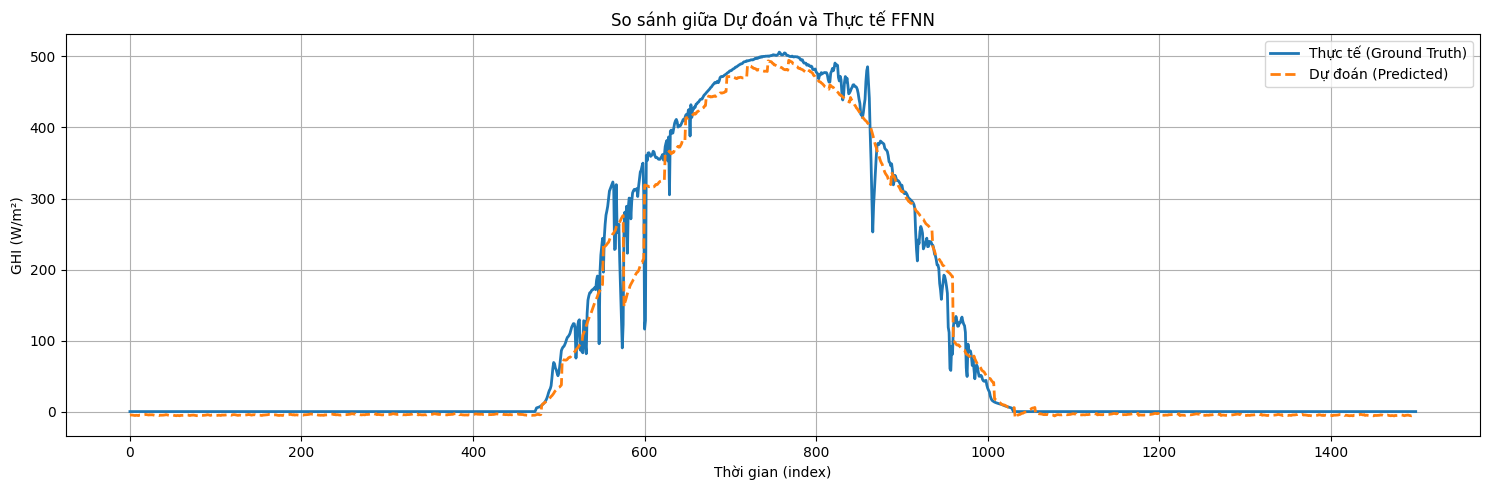

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(all_targets[:1500], label='Thực tế (Ground Truth)', linewidth=2)
plt.plot(all_scores[:1500], label='Dự đoán (Predicted)', linewidth=2, linestyle='--')

plt.title('So sánh giữa Dự đoán và Thực tế FFNN')
plt.xlabel('Thời gian (index)')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
from torchinfo import summary

model = LSTM(input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            seq_length=sequence_length).to(device)

summary(model, input_size=(16, 24, 8))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [16, 24]                  --
├─LSTM: 1-1                              [16, 24, 64]              52,224
├─Dropout: 1-2                           [16, 1536]                --
├─Linear: 1-3                            [16, 24]                  36,888
Total params: 89,112
Trainable params: 89,112
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 20.64
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.36
Estimated Total Size (MB): 0.57